# Mumbai Rain Forecasting
In this notebook we will try to predict mumbai Rainfall within the next months.

### Install skforecast

In [1]:
!pip install skforecast

#### Import dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.model_selection import backtesting_forecaster
import numpy as np
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


c:\Users\agust\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Load Dataset

In [3]:
# Load CSV
df = pd.read_csv('mumbai-monthly-rains.csv')
df.head()

,Year,Jan,Feb,Mar,April,May,June,July,Aug,Sept,Oct,Nov,Dec,Total
0,1901,13.116602,0.000000,0.000000,3.949669,17.139791,640.714036,888.369692,545.045796,64.271513,9.871696,0.000000,0.000000,2182.478796
1,1902,0.000000,0.000000,0.000000,0.000000,0.355001,247.998782,408.433730,566.595863,688.913455,28.654092,0.488864,19.526547,1960.966334
2,1903,0.000000,0.000000,0.844034,0.000000,220.568740,370.849048,902.447896,602.420828,264.589816,157.892877,0.000000,0.000000,2519.613240
3,1904,0.000000,0.000000,11.381769,0.000000,0.000000,723.081969,390.886799,191.581927,85.704754,38.679948,0.000000,0.000000,1441.317168
4,1905,0.662561,1.713452,0.000000,0.000000,0.000000,123.870892,581.827975,167.382149,172.297723,7.365924,24.903575,0.000000,1080.024250


#### Formatting the Dataset

First we will drop the Total column as we don't need it and it is kind of annoying for what we want to do.

In [4]:
df.drop('Total', axis=1, inplace=True)

Then we will put the months as rows instead of columns and we will use a new dataset from now on called df_melted.

In [5]:
df_melted=pd.melt(df, id_vars=['Year'], var_name='Month', value_name='Rainfall')

df_melted.head()

,Year,Month,Rainfall
0,1901,Jan,13.116602
1,1902,Jan,0.000000
2,1903,Jan,0.000000
3,1904,Jan,0.000000
4,1905,Jan,0.662561


Now we will see our months rows, as you can see, they are not homogeneous

In [6]:
df_melted['Month'].groupby(df_melted['Month']).count()

Month
April    121
Aug      121
Dec      121
Feb      121
Jan      121
July     121
June     121
Mar      121
May      121
Nov      121
Oct      121
Sept     121
Name: Month, dtype: int64

We want only the first 3 letters of the month, this is because there is a format that can map that first 3 letters to a dateformat type of data

In [7]:
df_melted['Month'] = df_melted['Month'].apply(lambda x: x[:3])
df_melted['Month'].groupby(df_melted['Month']).count()

Month
Apr    121
Aug    121
Dec    121
Feb    121
Jan    121
Jul    121
Jun    121
Mar    121
May    121
Nov    121
Oct    121
Sep    121
Name: Month, dtype: int64

Done! We can change Month to a numeric to a date now

In [8]:
# Convert 'Month' from abbreviated names to numerical values
df_melted['Month'] = pd.to_datetime(df_melted['Month'], format='%b')
df_melted.head()

,Year,Month,Rainfall
0,1901,1900-01-01,13.116602
1,1902,1900-01-01,0.000000
2,1903,1900-01-01,0.000000
3,1904,1900-01-01,0.000000
4,1905,1900-01-01,0.662561


Ok, this look promising, now we will concatenate the year and the to create a Date column 

In [9]:
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'].dt.strftime('%m'))
df_melted.head()

,Year,Month,Rainfall,Date
0,1901,1900-01-01,13.116602,1901-01-01
1,1902,1900-01-01,0.000000,1902-01-01
2,1903,1900-01-01,0.000000,1903-01-01
3,1904,1900-01-01,0.000000,1904-01-01
4,1905,1900-01-01,0.662561,1905-01-01


We drop the columns Year and Month as we don't need them anymore.

In [10]:
df_melted.drop(['Year', 'Month'], axis=1, inplace=True)

We set the Date as the index of the dataframe and sort it by month, also we will fill any month that is empty.

In [11]:
# Set the date as index
df_melted.set_index('Date', inplace = True)
# Sort the data
df_melted.sort_index(inplace = True)
# Set the dataset frequency to be (M)onthly data
df_melted = df_melted.asfreq('M', method = 'bfill') 
# Fill missing value with the latest available data
df_melted.ffill(inplace = True)

Let's see what we've got...

In [12]:
df_melted.head()

,Rainfall
Date,
1901-01-31,0.000000
1901-02-28,0.000000
1901-03-31,3.949669
1901-04-30,17.139791
1901-05-31,640.714036


#### Understanding the information

<Axes: xlabel='Date'>

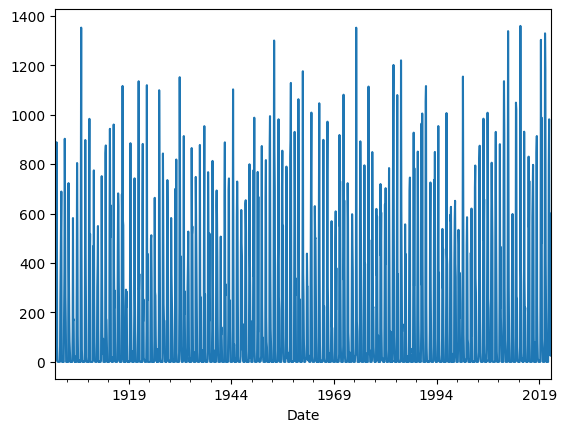

In [13]:
df_melted['Rainfall'].plot()

We can see that there where years with more and less rainfalls... But let's see how they distribute in monthly bases

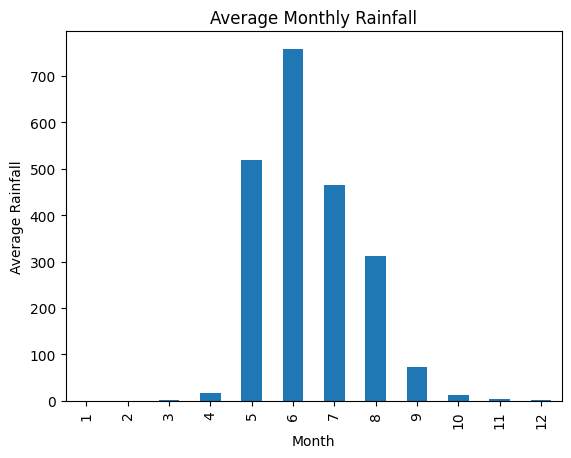

In [14]:
# Group by month and calculate the mean rainfall
monthly_rainfall = df_melted.groupby(df_melted.index.month).mean()

# Plot the monthly rainfall
monthly_rainfall.plot(kind='bar', y='Rainfall', legend=False)
plt.xlabel('Month')
plt.ylabel('Average Rainfall')
plt.title('Average Monthly Rainfall')
plt.show()

We can see that there are 6 months that have very little rainfalls (Jan, Feb, Mar, Oct, Nov, Dec) and that the month with more rainfalls in general is June.

#### Preparing for fitting the model
We will scale the Rainfall data, this is because models usually makes better predictions with more homogeneous data.

In [15]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'Rainfall' column
df_melted['Rainfall_scaled'] = scaler.fit_transform(df_melted[['Rainfall']])

# Display the first few rows to verify the scaling
df_melted.head()

,Rainfall,Rainfall_scaled
Date,,
1901-01-31,0.000000,0.000000
1901-02-28,0.000000,0.000000
1901-03-31,3.949669,0.002907
1901-04-30,17.139791,0.012614
1901-05-31,640.714036,0.471518


Now we will split our model into train and test...<br>
As we have a date as the index, we can use the date to split it.<br>
We will try to predict what happend between 2020 and 2021 based on the previous info. <br>
(To check the first and last date you can use df_melted.head() and df_melted.tail())

In [16]:
train_start = '1901-01-31'
train_end = '2019-12-31'

test_start = '2020-01-01'
test_end = '2021-11-30'

#### Defining the Model

In [17]:
# Define the forecaster with multiple series
forecaster = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 30,
    
)

##### Tuning the model
We will tune our model to make a better prediction, we will need to set some variables here and the model will try all of them to see what are best to make a certain prediction

In [18]:
# Parameter Grid for Regressor
param_grid = {
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'max_depth' : [None, 1, 3, 5, 10, 15, 20],
    # min_samples_split: The minimum number of samples required to split an internal node.
    'min_samples_split' : [2, 3, 4, 5, 6, 10],
    # ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
    'ccp_alpha' : [0.0, 0.001, 0.01, 0.0001]
}

# lags_grid: The number of previous observations to consider
lags_grid = [30, 36, 50, 100, 150, [1,2,3,4,5,7,9,13,15,20,50], 10, 20, 5, 8, [10, 14, 20], [1, 5, 10, 15, 20, 25]]

##### Grid search forecaster
The grid_search_forecaster function will use the parameters we set to try to find the best model according to the input data that we will use (In this case, the Rainfall_scaled variable we create earlier)

In [19]:
# Grid Search with Refit and Increasing Train Size
grid_forecaster = grid_search_forecaster(
    # forecaster - our model
    forecaster = forecaster,
    # y - target variable
    y = df_melted.loc[train_start:test_end, 'Rainfall_scaled'],
    # param_grid - dictionary with parameters to test
    param_grid = param_grid,
    # lag_grid - list with lags to test
    lags_grid = lags_grid,
    # steps - number of steps to forecast
    steps = len(df_melted.loc[test_start:test_end, 'Rainfall_scaled']),
    # refit - refit the best model with all data
    refit = True,
    # metric - metric to optimize
    metric = 'mean_squared_error',
    # initial_train_size - initial size of the train data
    initial_train_size = len(df_melted.loc[train_start:train_end]),
    # fixed_train_size - if True, the training size is fixed
    fixed_train_size = False,
    # return_best - return the best model
    return_best = True,
    # verbose - show all messages
    verbose = False
)




Number of models compared: 2016.


lags grid: 100%|██████████| 12/12 [01:23<00:00,  6.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_split': 4}
  Backtesting metric: 0.01455900823330472



##### Backtesting
This will give use the RMSE of the model.

In [20]:
# Backtest RMSE
np.sqrt(grid_forecaster.iloc[0]['mean_squared_error'])

0.12066071536877576

##### Fitting the Model
We will fit our model with the train data.

In [21]:
# Fit the model using train data with multiple series
forecaster.fit(y = df_melted.loc[train_start:train_end, 'Rainfall_scaled'])

##### Making predictions
Now we will predict the test data, this will give us two columns, one with the index (Date predicted) and other one with the Values

In [22]:
# Predict the test period with multiple series
predicted_test = forecaster.predict(steps = len(df_melted.loc[test_start:test_end, 'Rainfall_scaled']))

We will inverse_transform the values using our scaler to make an array with the real values predicted

In [23]:
predicted_test_scaled = scaler.inverse_transform(predicted_test.values.reshape(-1, 1))

##### Converting prediction to Dataset
Ok, as the title says, now that we have the predictions scaled back to their real value, we will put them into a dataset

In [24]:
predicted_rainfall = pd.DataFrame({
    'Date': df_melted.loc[test_start:test_end].index,
    'Rainfall_scaled': predicted_test.values,
    'Rainfall': predicted_test_scaled.flatten()
})
predicted_rainfall


,Date,Rainfall_scaled,Rainfall
0,2020-01-31,0.001299,1.764751
1,2020-02-29,0.001299,1.764751
2,2020-03-31,0.001299,1.764751
3,2020-04-30,0.001246,1.693773
4,2020-05-31,0.608561,826.932466
5,2020-06-30,0.975684,1325.792007
6,2020-07-31,0.755509,1026.611158
7,2020-08-31,0.221316,300.731150
8,2020-09-30,0.054920,74.627149
9,2020-10-31,0.004290,5.829473


##### Results
Let's compare our prediction to what happened in our test data

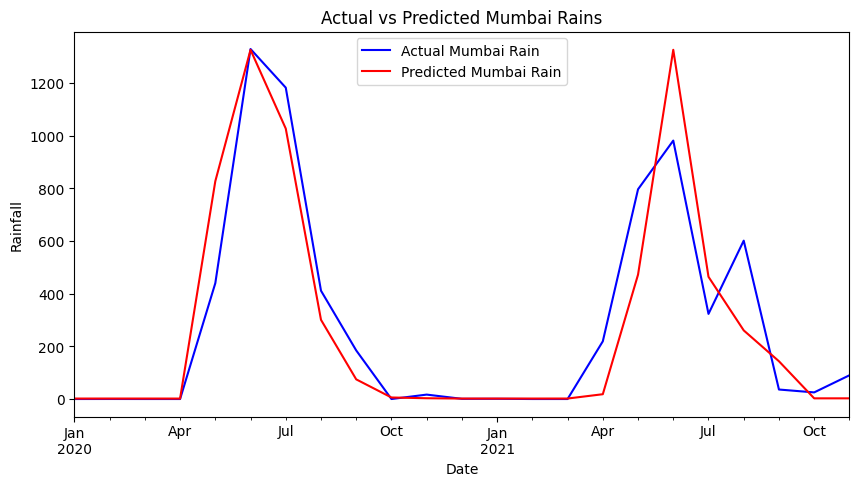

In [25]:
### Plot Rainfall
fig, ax = plt.subplots(figsize=(10, 5))

# Set 'Date' as the index for predicted_rainfall
predicted_rainfall.set_index('Date', inplace=True)

# Plot actual and predicted rainfall
df_melted.loc[test_start:test_end, 'Rainfall'].plot(ax=ax, label="Actual Mumbai Rain", color='blue')
predicted_rainfall['Rainfall'].plot(ax=ax, label='Predicted Mumbai Rain', color='red')

# Set the title and labels
ax.set_title('Actual vs Predicted Mumbai Rains')
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')
ax.legend()
plt.show()

### Conclusion

In this notebook, we successfully forecasted the monthly rainfall in Mumbai using historical data. We followed a systematic approach that included:

1. **Data Preparation**: We cleaned and formatted the dataset, converting the monthly data into a time series format suitable for forecasting.
2. **Exploratory Data Analysis**: We visualized the data to understand the trends and patterns in Mumbai rainfall over the years.
3. **Feature Scaling**: We scaled the rainfall data to improve the performance of our forecasting model.
4. **Model Training and Tuning**: We used the `ForecasterAutoreg` class from the `skforecast` library with a `DecisionTreeRegressor` to train our model. We performed grid search to find the best hyperparameters.
5. **Model Evaluation**: We backtested our model to evaluate its performance and calculated the RMSE to quantify the prediction error.
6. **Prediction**: We made predictions for the test period and compared them with the actual rainfall data.

The results show that our model can reasonably predict the monthly rainfall in Mumbai, capturing the general trends and seasonal patterns. However, there is always room for improvement, and further tuning or the use of more advanced models could potentially yield even better results.

Overall, this project demonstrates the effectiveness of time series forecasting techniques in predicting weather patterns, which can be crucial for planning and decision-making in various sectors.